In [114]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.grid_search import GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import scale, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import matplotlib.patches as mpatches

In [64]:
train = pd.read_csv(r"G:\islr_datasets\santander\train.csv", index_col = 0)
test = pd.read_csv(r"G:\islr_datasets\santander\test.csv", index_col = 0)

In [65]:
train.head()

,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
ID,,,,,,,,,,,,,,,,,,,,,
000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [66]:
Y_train = train.target
Y_train = np.log1p(Y_train)
test_ID = test.index

train = train.drop(['target'], 1)

### **Removing duplicate columns**

In [67]:
#train_without_duplicates = train.T.drop_duplicates().T
#columns_not_to_be_dropped = train_without_duplicates.columns
#columns_to_be_dropped = [col for col in test.columns if col not in columns_not_to_be_dropped]

In [68]:
#test_without_duplicates = test.drop(columns_to_be_dropped, 1)

In [69]:
#train_without_duplicates.shape, test_without_duplicates.shape

### **Removing columns with constant values**

In [70]:
col_with_std_zero = train.loc[:, train.std(axis = 0) == 0].columns
train2 = train.loc[:, train.std(axis = 0) != 0]
test2 = test.drop(col_with_std_zero, 1)

In [71]:
test2.fillna(train2.median(),inplace = True)

In [72]:
total_df = pd.concat([train2, test2])

# Scaling columns with major outliers

In [12]:
for col in total_df.columns:    
    

    # Detect outliers in this column
    data = total_df[col].values
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    
    # If there are crazy high values, do a log-transform
    if len(outliers) > 0:
        non_zero_idx = data != 0
        total_df.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
    
    # Scale non-zero column values
    nonzero_rows = total_df[col] != 0
    if  np.isfinite(total_df.loc[nonzero_rows, col]).all():
        total_df.loc[nonzero_rows, col] = scale(total_df.loc[nonzero_rows, col])
        if  np.isfinite(total_df[col]).all():
            # Scale all column values
            total_df[col] = scale(total_df[col])

# Checking distribution of target values

G:\anaconda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
G:\anaconda\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


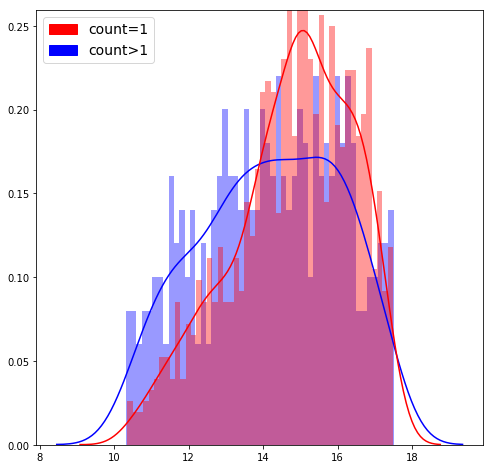

In [136]:
c = Y_train.value_counts()
plt.figure(figsize=(8,8))
sns.distplot(c[c>1].index,bins = 50,color = 'blue')
sns.distplot(c[c==1].index,bins = 50 , color ='red')
patch1 = mpatches.Patch(color='red', label='count=1')
patch2 = mpatches.Patch(color='blue', label='count>1')
plt.legend(handles=[patch1,patch2])
plt.rcParams["legend.fontsize"] = 14
plt.show()

In [ ]:
train2,test2 = total_df.iloc[:len(train2),:],total_df.iloc[len(train2):,:]

In [137]:
def select_features_using_sparsity(x_train,x_test):
    train = ((x_train != 0).sum(axis = 0))/float(len(x_train))
    test = ((x_test !=0).sum(axis = 0))/float(len(x_test))
    plt.scatter(train.values,test.values,2)
    plt.xlabel('fraction of non zero train data')
    plt.ylabel('fraction of non zero test data')
    plt.show()

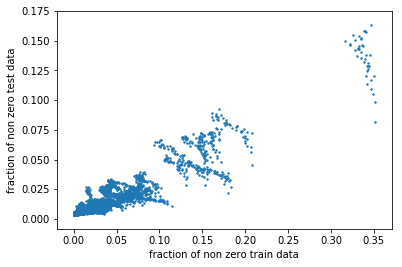

Wall time: 7.9 s


In [91]:
%%time
select_features_using_sparsity(train2,test2)

In [100]:
train = ((train2 != 0).sum(axis = 0))/float(len(train2))
sparse_cols = train[train>0.25].index
print(len(sparse_cols))

40


In [103]:
def filter_using_cols(x_train,x_test,cols):
    if (set(cols) < set(x_train.columns)) & (set(cols) < set(x_test.columns)) :
        return x_train[cols],x_test[cols]
    else:
        print("These columns do not exist in the dataframe")

# Removing features by importance and create transformations of n most important features.

In [47]:
def remove_features_using_importance(x_train, y_train, x_test):
    
    def rmsle(actual, predicted):
        return np.sqrt(np.mean(np.power(np.log1p(actual)-np.log1p(predicted), 2)))
    
    num_of_features = 1000
    
    print("Split train and test")
    x1, x2, y1, y2 = train_test_split(x_train, y_train, test_size = 0.20, random_state = 42)
    model = RandomForestRegressor(n_jobs = -1, random_state = 7)
    model.fit(x1, y1)
    print(rmsle(np.expm1(y2), np.expm1(model.predict(x2))))
    
    print("Get columns by feature importances")
    col_df = pd.DataFrame({'importance': model.feature_importances_, 'feature': x_train.columns})
    col_df_sorted = col_df.sort_values(by = ['importance'], ascending = [False])
    columns = col_df_sorted[:num_of_features]['feature'].values
    
    
    
    x_train = x_train[columns]
    x_test = x_test[columns]
    
    for j in columns[:30]:
        x_train['square' + str(j)] = x_train[j]**2
        x_test['square' + str(j)] = x_test[j]**2
        x_train['cube' + str(j)] = x_train[j]**3
        x_test['cube' + str(j)] = x_test[j]**3
        x_train['sqrt' + str(j)] = x_test[j]**0.5
        x_test['sqrt' + str(j)] = x_test[j]**0.5
    
    return x_train, x_test

### **Removing features having different distributions in train and test set**

In [48]:
def remove_features_having_different_distributions(train, test):
    return

### **Adding aggregate features**

In [50]:
def add_row_features(train, test):
    weight = ((train != 0).sum()/len(train)).values
    
    tmp_train = train[train != 0]
    tmp_test = test[test != 0]

    print("Adding row features.....")
    
    print("weight count")
    train["weight_count"] = (tmp_train * weight).sum(axis = 1)
    test["weight_count"] = (tmp_test * weight).sum(axis = 1)
    
    print("number of non-zero values")
    train["count_non_0"] = (train != 0).sum(axis = 1)
    test["count_non_0"] = (test != 0).sum(axis = 1)
    
    print("number of different")
    train["num_different"] = tmp_train.nunique(axis = 1)
    test["num_different"] = tmp_test.nunique(axis = 1)
    
    print("sum")
    train["sum"] = train.sum(axis=1)
    test["sum"] = test.sum(axis=1)

    print("variance")
    train["var"] = tmp_train.var(axis=1)
    test["var"] = tmp_test.var(axis=1)

    print("mean")
    train["mean"] = tmp_train.mean(axis=1)
    test["mean"] = tmp_test.mean(axis=1)
    
    print("median")
    train["median"] = tmp_train.median(axis=1)
    test["median"] = tmp_test.median(axis=1)

    print("std")
    train["std"] = tmp_train.std(axis=1)
    test["std"] = tmp_test.std(axis=1)

    print("max")
    train["max"] = tmp_train.max(axis=1)
    test["max"] = tmp_test.max(axis=1)

    print("min")
    train["min"] = tmp_train.min(axis=1)
    test["min"] = tmp_test.min(axis=1)
    
    train['the_kur'] = tmp_train.kurtosis(axis=1)
    test['the_kur'] = tmp_test.kurtosis(axis=1)
    print("\nTrain shape: {}\nTest shape: {}".format(train.shape, test.shape))
    
    # Remove an NA valuess
    train = train.fillna(0)
    test = test.fillna(0)
    
    del(tmp_train)
    del(tmp_test)
    return train, test

### **Add dimensional reduction features back to dataset**

In [51]:
def add_decomposed_features_back_to_df(train, 
                                       test,
                                       total,
                                       n_components = 10,
                                       use_pca = False,
                                       use_tsvd = False,
                                       use_ica = False,
                                       use_fa = False,
                                       use_grp = False,
                                       use_srp = False):
    N_COMP = n_components
    ntrain = len(train)

    print("\nStart decomposition process...")
    
    if use_pca:
        print("PCA")
        pca = PCA(n_components = N_COMP, random_state = 42)
        pca_results = pca.fit_transform(total)
        pca_results_train = pca_results[:ntrain]
        pca_results_test = pca_results[ntrain:]

    if use_tsvd:
        print("tSVD")
        tsvd = TruncatedSVD(n_components = N_COMP, random_state=42)
        tsvd_results = tsvd.fit_transform(total)
        tsvd_results_train = tsvd_results[:ntrain]
        tsvd_results_test = tsvd_results[ntrain:]

    if use_ica:
        print("ICA")
        ica = FastICA(n_components = N_COMP, random_state=42)
        ica_results = ica.fit_transform(total)
        ica_results_train = ica_results[:ntrain]
        ica_results_test = ica_results[ntrain:]

    if use_fa:
        print("FA")
        fa = FactorAnalysis(n_components = N_COMP, random_state=42)
        fa_results = fa.fit_transform(total)
        fa_results_train = fa_results[:ntrain]
        fa_results_test = fa_results[ntrain:]

    if use_grp:
        print("GRP")
        grp = GaussianRandomProjection(n_components = N_COMP, eps=0.1, random_state=42)
        grp_results = grp.fit_transform(total)
        grp_results_train = grp_results[:ntrain]
        grp_results_test = grp_results[ntrain:]

    if use_srp:
        print("SRP")
        srp = SparseRandomProjection(n_components = N_COMP, dense_output=True, random_state=42)
        srp_results = srp.fit_transform(total)
        srp_results_train = srp_results[:ntrain]
        srp_results_test = srp_results[ntrain:]

    print("Append decomposition components to datasets...")
    for i in range(1, N_COMP + 1):
        
        if use_pca:
            train['pca_' + str(i)] = pca_results_train[:, i - 1]
            test['pca_' + str(i)] = pca_results_test[:, i - 1]
        
        if use_tsvd:
            train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
            test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]
        
        if use_ica:
            train['ica_' + str(i)] = ica_results_train[:, i - 1]
            test['ica_' + str(i)] = ica_results_test[:, i - 1]
        
        if use_fa:
            train['fa_' + str(i)] = fa_results_train[:, i - 1]
            test['fa_' + str(i)] = fa_results_test[:, i - 1]

        if use_grp:
            train['grp_' + str(i)] = grp_results_train[:, i - 1]
            test['grp_' + str(i)] = grp_results_test[:, i - 1]
        
        if use_srp:
            train['srp_' + str(i)] = srp_results_train[:, i - 1]
            test['srp_' + str(i)] = srp_results_test[:, i - 1]
    print("\nTrain shape: {}\nTest shape: {}".format(train.shape, test.shape))
    
    return train, test

### **Building a new dataframe with the dimensional reduction rechniques**

In [52]:
def use_decomposed_features_as_new_df(train, 
                                      test,
                                      total,
                                      n_components,
                                      use_pca = False,
                                      use_tsvd = False,
                                      use_ica = False,
                                      use_fa = False,
                                      use_grp = False,
                                      use_srp = False):
    N_COMP = n_components
    ntrain = len(train)

    print("\nStart decomposition process...")
    
    if use_pca:
        print("PCA")
        pca = PCA(n_components = N_COMP, random_state = 42)
        pca_results = pca.fit_transform(total)
        pca_results_train = pca_results[:ntrain]
        pca_results_test = pca_results[ntrain:]

    if use_tsvd:
        print("tSVD")
        tsvd = TruncatedSVD(n_components = N_COMP, random_state=42,set_copy = False)
        tsvd_results = tsvd.fit_transform(total)
        tsvd_results_train = tsvd_results[:ntrain]
        tsvd_results_test = tsvd_results[ntrain:]

    if use_ica:
        print("ICA")
        ica = FastICA(n_components = N_COMP, random_state=42)
        ica_results = ica.fit_transform(total)
        ica_results_train = ica_results[:ntrain]
        ica_results_test = ica_results[ntrain:]

    if use_fa:
        print("FA")
        fa = FactorAnalysis(n_components = N_COMP, random_state=42)
        fa_results = fa.fit_transform(total)
        fa_results_train = fa_results[:ntrain]
        fa_results_test = fa_results[ntrain:]

    if use_grp:
        print("GRP")
        grp = GaussianRandomProjection(n_components = N_COMP, eps=0.1, random_state=42)
        grp_results = grp.fit_transform(total)
        grp_results_train = grp_results[:ntrain]
        grp_results_test = grp_results[ntrain:]

    if use_srp:
        print("SRP")
        srp = SparseRandomProjection(n_components = N_COMP, dense_output=True, random_state=42)
        srp_results = srp.fit_transform(total)
        srp_results_train = srp_results[:ntrain]
        srp_results_test = srp_results[ntrain:]
        
    print("Append decomposition components together...")
    train_decomposed = np.concatenate([srp_results_train, grp_results_train, ica_results_train, pca_results_train, tsvd_results_train], axis=1)
    test_decomposed = np.concatenate([srp_results_test, grp_results_test, ica_results_test, pca_results_test, tsvd_results_test], axis=1)

    train_with_only_decomposed_features = pd.DataFrame(train_decomposed)
    test_with_only_decomposed_features = pd.DataFrame(test_decomposed)
    
    for agg_col in ['sum', 'var', 'mean', 'median', 'std', 'weight_count', 'count_non_0', 'num_different', 'max', 'min']:
        train_with_only_decomposed_features[col] = train[col]
        test_with_only_decomposed_features[col] = test[col]
    
    # Remove any NA
    train_with_only_decomposed_features = train_with_only_decomposed_features.fillna(0)
    test_with_only_decomposed_features = test_with_only_decomposed_features.fillna(0)
    
    return train_with_only_decomposed_features, test_with_only_decomposed_features

### **Build validation set using adversarial validation**

In [109]:
def generate_adversarial_validation_set(train, test):
    x_test = test.drop(["is_test", "target"], 1)

    train, val = train.iloc[1000:], train.iloc[:1000]
    train = train.drop(["is_test", "predicted_probs"], 1)
    val = val.drop(["is_test", "predicted_probs"], 1)

    x_train, y_train = train.drop("target", 1), train.target
    x_val, y_val = val.drop("target", 1), val.target
    
    return x_train, y_train, x_val, y_val, x_test

def get_training_set_with_test_set_similarity_predictions(X_train, Y_train, X_test):
    
    print("Add target column")
    X_train['target'] = Y_train
    X_test['target'] = 0
    
    X_train["is_test"] = 0
    X_test["is_test"] = 1
    assert(np.all(X_train.columns == X_test.columns))
    
    print("Concat train and test data")
    total = pd.concat([X_train, X_test])
    total = total.fillna(0)
    
    x = total.drop(["is_test", "target"], axis = 1)
    y = total.is_test
    
    print("Start cross-validating")
    n_estimators = 100
    classifier = RandomForestClassifier(n_estimators = n_estimators, n_jobs = -1)
    predictions = np.zeros(y.shape)
    
    stratified_kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 5678)
    
    for fold_index, (train_indices, test_indices) in enumerate(stratified_kfold.split(x, y)):
        print("Fold - " + str(fold_index))
        
        x_train = x.iloc[train_indices]
        y_train = y.iloc[train_indices]
        x_test = x.iloc[test_indices]
        y_test = y.iloc[test_indices]
        
        classifier.fit(x_train, y_train)
        
        predicted_probabilities = classifier.predict_proba(x_test)[:, 1]
        
        auc = roc_auc_score(y_test, predicted_probabilities)
        print("AUC Score - " + str(auc) + "%")
        
        predictions[test_indices] = predicted_probabilities
    total['predicted_probs'] = predictions
    
    print("Generating training set")
    total = total[total.is_test == 0]
    
    print("Sorting according to predictions")
    train_set_with_predictions_for_test_set_similarity = total.sort_values(["predicted_probs"], ascending = False)
    
    return train_set_with_predictions_for_test_set_similarity, X_test

### **Building the model**

In [54]:
def run_lgb(x_train, y_train, x_val, y_val, x_test, test_ID):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(x_train, label = y_train)
    lgval = lgb.Dataset(x_val, label = y_val)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets = [lgval], 
                      early_stopping_rounds = 100, 
                      verbose_eval = 50, 
                      evals_result = evals_result)
    
    y_pred_test = np.expm1(model.predict(x_test, num_iteration = model.best_iteration))
    print("LightGBM Training Completed...")


    sub = pd.DataFrame(y_pred_test)
    sub.columns = ['target']
    sub.insert(0, 'ID', test_ID)
    print(sub.head())
    sub.iloc[:-1,:].to_csv('predictions.csv', index = False)

### **Creating multiple submission files**

In [104]:
train_with_features_by_importances, test_with_features_by_importances = filter_using_cols(train2.copy(),test2.copy(),sparse_cols)

In [105]:
train_with_aggregate_features, test_with_aggregate_features = add_row_features(train_with_features_by_importances.copy(), 
                                                                               test_with_features_by_importances.copy())

Adding row features.....
weight count
number of non-zero values
number of different
sum
variance
mean
median
std
max
min

Train shape: (4459, 51)
Test shape: (49343, 51)


#### **1. Add row features and all decomposed features**

In [106]:
%%time
PERC_TRESHOLD = 0.98   ### Percentage of zeros in each feature ###
N_COMP = 10            ### Number of decomposition components ###

print("tSVD")
tsvd = TruncatedSVD(n_components=N_COMP, random_state=17)        
tsvd_results_train = tsvd.fit_transform(train_with_aggregate_features)
tsvd_results_test = tsvd.transform(test_with_aggregate_features)
print("Append decomposition components to datasets...")
for i in range(1, N_COMP + 1):
    train_with_aggregate_features['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_with_aggregate_features['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]
    
print("PCA")
tsvd = PCA(n_components=N_COMP, random_state=17)        
tsvd_results_train = tsvd.fit_transform(train_with_aggregate_features)
tsvd_results_test = tsvd.transform(test_with_aggregate_features)
print("Append decomposition components to datasets...")
for i in range(1, N_COMP + 1):
    train_with_aggregate_features['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_with_aggregate_features['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]


tSVD
Append decomposition components to datasets...
PCA
Append decomposition components to datasets...
Wall time: 4.11 s


In [107]:
X_train = train_with_aggregate_features.copy()
X_test = test_with_aggregate_features.copy()

In [110]:
training_set, testing_set = get_training_set_with_test_set_similarity_predictions(X_train.copy(), Y_train.copy(), X_test.copy())

Add target column
Concat train and test data
Start cross-validating
Fold - 0
AUC Score - 0.9065628568325785%
Fold - 1
AUC Score - 0.8997078658679827%
Fold - 2
AUC Score - 0.9006072032413859%
Fold - 3
AUC Score - 0.9029611840419094%
Fold - 4
AUC Score - 0.9139125798361036%
Generating training set
Sorting according to predictions


In [111]:
x_train, y_train, x_val, y_val, x_test = generate_adversarial_validation_set(training_set.copy(), testing_set.copy())
print(x_train.shape, x_val.shape, x_test.shape)

(3459, 61) (1000, 61) (49343, 61)


In [112]:
run_lgb(x_train, y_train, x_val, y_val, x_test, test_ID)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.61207
[100]	valid_0's rmse: 1.56216
[150]	valid_0's rmse: 1.53207
[200]	valid_0's rmse: 1.51654
[250]	valid_0's rmse: 1.50836
[300]	valid_0's rmse: 1.50458
[350]	valid_0's rmse: 1.50341
[400]	valid_0's rmse: 1.50287
[450]	valid_0's rmse: 1.50361
Early stopping, best iteration is:
[364]	valid_0's rmse: 1.50272
LightGBM Training Completed...
          ID        target
0  000137c73  1.946672e+06
1  00021489f  1.946672e+06
2  0004d7953  2.279491e+06
3  00056a333  5.058332e+06
4  00056d8eb  1.946672e+06
